# Packages

In [19]:
import numpy as np
import sys, os
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *
import pandas as pd
from scipy.stats import chi2
from scipy.special import sph_harm 
from scipy.special import lpmv
import healpy as hp
from healpy.sphtfunc import map2alm
#import pyshtools

%matplotlib inline
#%load_ext autoreload
#%autoreload 2

%config InlineBackend.figure_format = 'retina'

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 
pd.set_option('display.max_columns', None)
pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

# Load data onto Healpix

## Load data

In [336]:
quasars_pd = pd.read_csv("allwise.csv")
quasars_pd.columns.values

array(['source_id', 'parallax', 'parallax_error', 'ra', 'dec', 'ra_error', 'dec_error', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error', 'pmra_pmdec_corr', 'astrometric_gof_al',
       'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'radial_velocity', 'radial_velocity_error', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_weight_al', 'astrometric_chi2_al', 'matched_observations', 'phot_g_mean_mag'], dtype=object)

In [337]:
ra = quasars_pd['ra'].values
dec = quasars_pd['dec'].values
pmra = quasars_pd['pmra'].values
pmdec = quasars_pd['pmdec'].values
pmra_error = quasars_pd['pmra_error']
pmdec_error = quasars_pd['pmdec_error']
pm_var = 0.5*(pmra_error**2 + pmdec_error**2)

In [338]:
quasars_icrs = SkyCoord(ra=ra*u.deg, 
                        dec=dec*u.deg, 
                        pm_ra_cosdec=pmra*u.mas/u.yr, 
                        pm_dec=pmdec*u.mas/u.yr, 
                        frame='icrs')
quasars_gal = quasars_icrs.transform_to('galactic')
l_gal = quasars_gal.l.value
b_gal = quasars_gal.b.value
pm_l_gal = quasars_gal.pm_l_cosb.value
pm_b_gal = quasars_gal.pm_b.value

## Healpix

In [490]:
nside = 16
npix = hp.nside2npix(nside)
lmax = 3*nside-1
print('npix =', npix, ', lmax =', lmax, end=None)
#map = np.arange(npix)
#hp.mollview(map, title="Mollview image RING", xsize=2000)

q_pix = hp.ang2pix(nside,np.deg2rad(90-b_gal),np.deg2rad(l_gal))

pix_coords = np.asarray(hp.pixelfunc.pix2ang(nside,np.arange(npix))).transpose()

quasars_map = np.zeros(hp.nside2npix(nside))
pm_N_map = np.zeros(hp.nside2npix(nside))
pm_l_map = np.zeros(hp.nside2npix(nside))
pm_b_map = np.zeros(hp.nside2npix(nside))

npix = 3072 , lmax = 47


In [491]:
for idx, ipix in enumerate(tqdm_notebook((q_pix))):
    quasars_map[ipix] += 1
    pm_N_map[ipix] += 1/pm_var[idx]
    pm_l_map[ipix] += pm_l_gal[idx]/pm_var[idx]
    pm_b_map[ipix] += pm_b_gal[idx]/pm_var[idx]

pm_l_map /= (pm_N_map + 10**(-10))
pm_b_map /= (pm_N_map + 10**(-10))
pm_mag_map = np.sqrt(pm_l_map**2 + pm_b_map**2)
pm_N_map = np.reciprocal(pm_N_map + 10**(-10))

## Plots

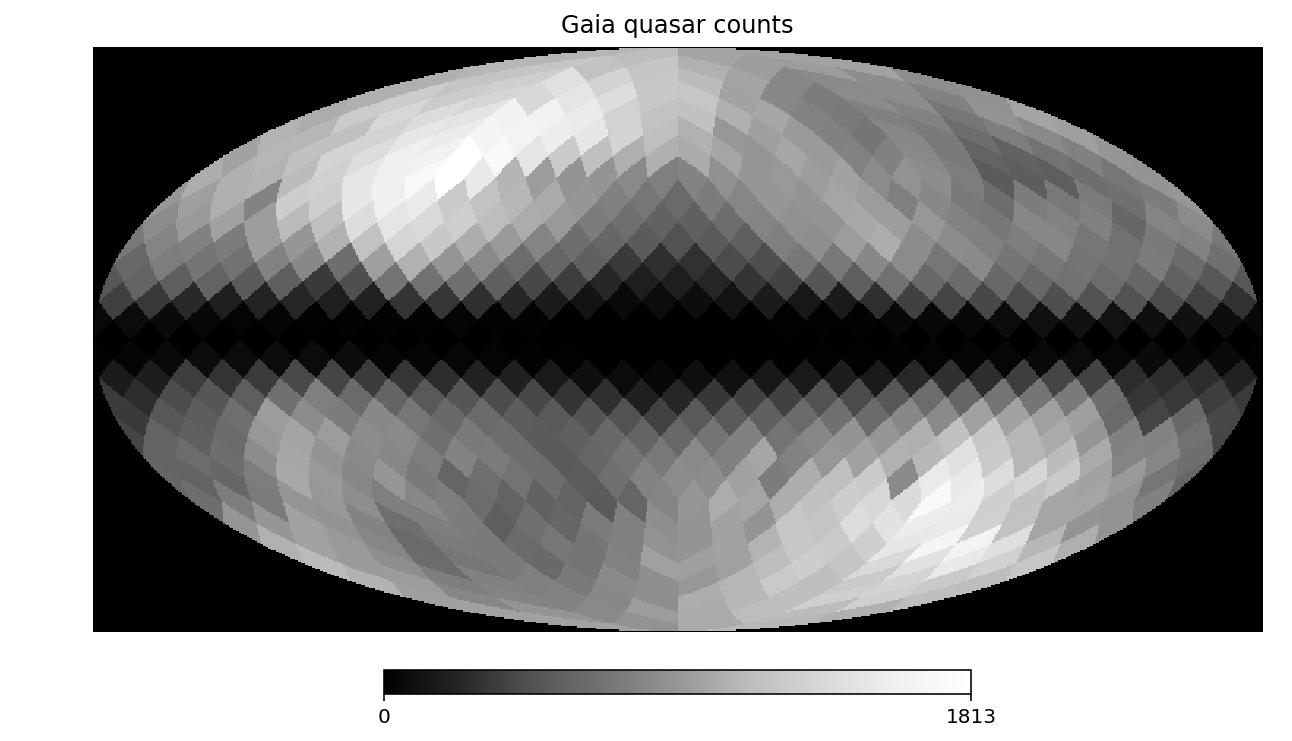

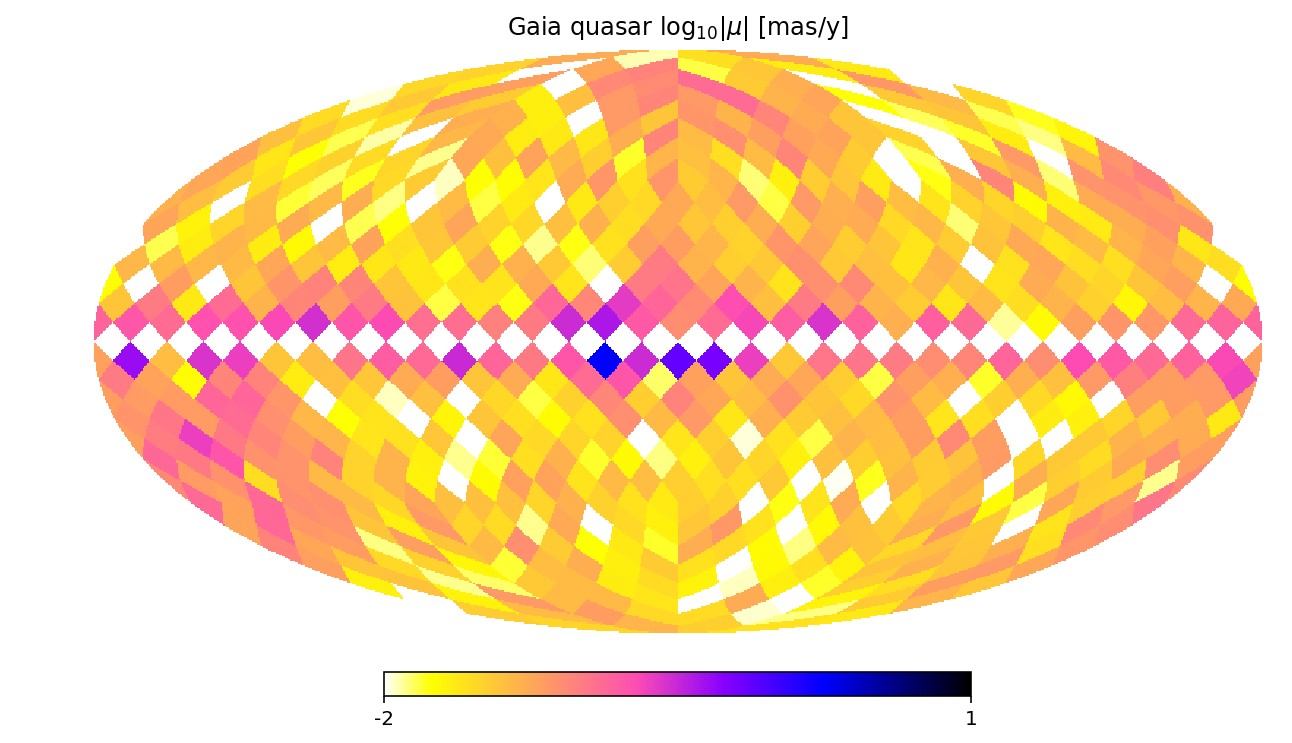

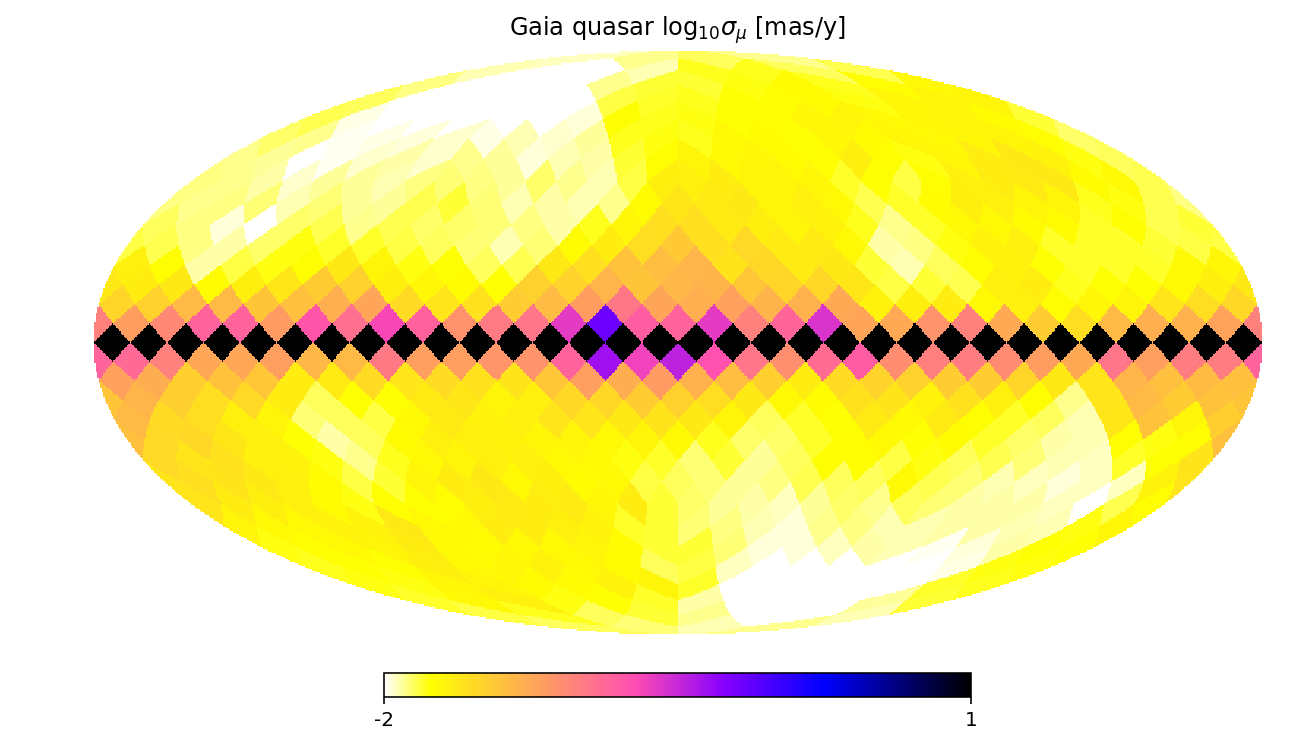

In [341]:
fig_quasars_map = hp.mollview(quasars_map, title="Gaia quasar counts", min=0,cmap='Greys_r')
plt.savefig('quasars_map.pdf', figsize=(8,6), dpi=300)
fig_quasars_pm_mag_map = hp.mollview(np.log10(pm_mag_map+10**(-100)), title="Gaia quasar $\log_{10} |\mu|$ [mas/y]", min=-2, max=1,cmap='gnuplot2_r')
plt.savefig('quasars_pm_mag_map.pdf', figsize=(8,6), dpi=300)
fig_quasars_pm_N_map = hp.mollview(np.log10(np.sqrt(pm_N_map)), title="Gaia quasar $\log_{10} \sigma_\mu$ [mas/y]", min=-2, max=1,cmap='gnuplot2_r')
plt.savefig('quasars_pm_N_map.pdf', figsize=(8,6), dpi=300)

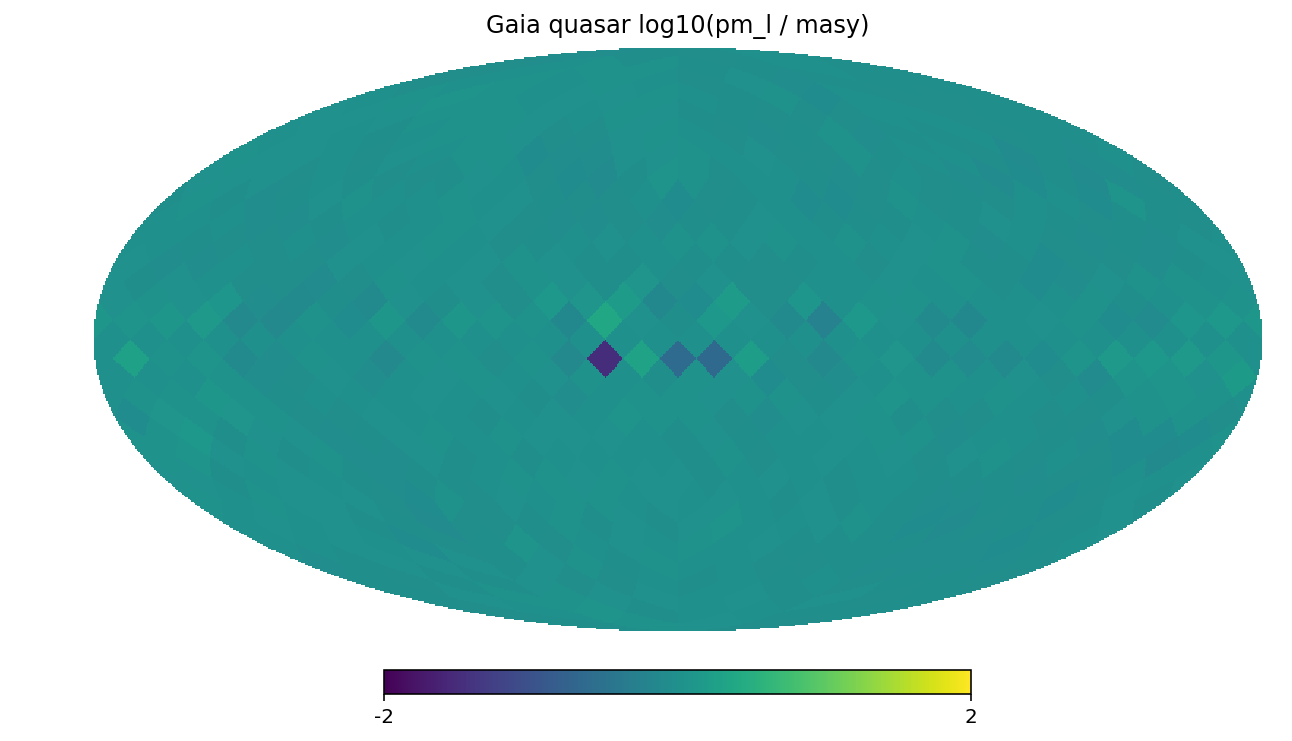

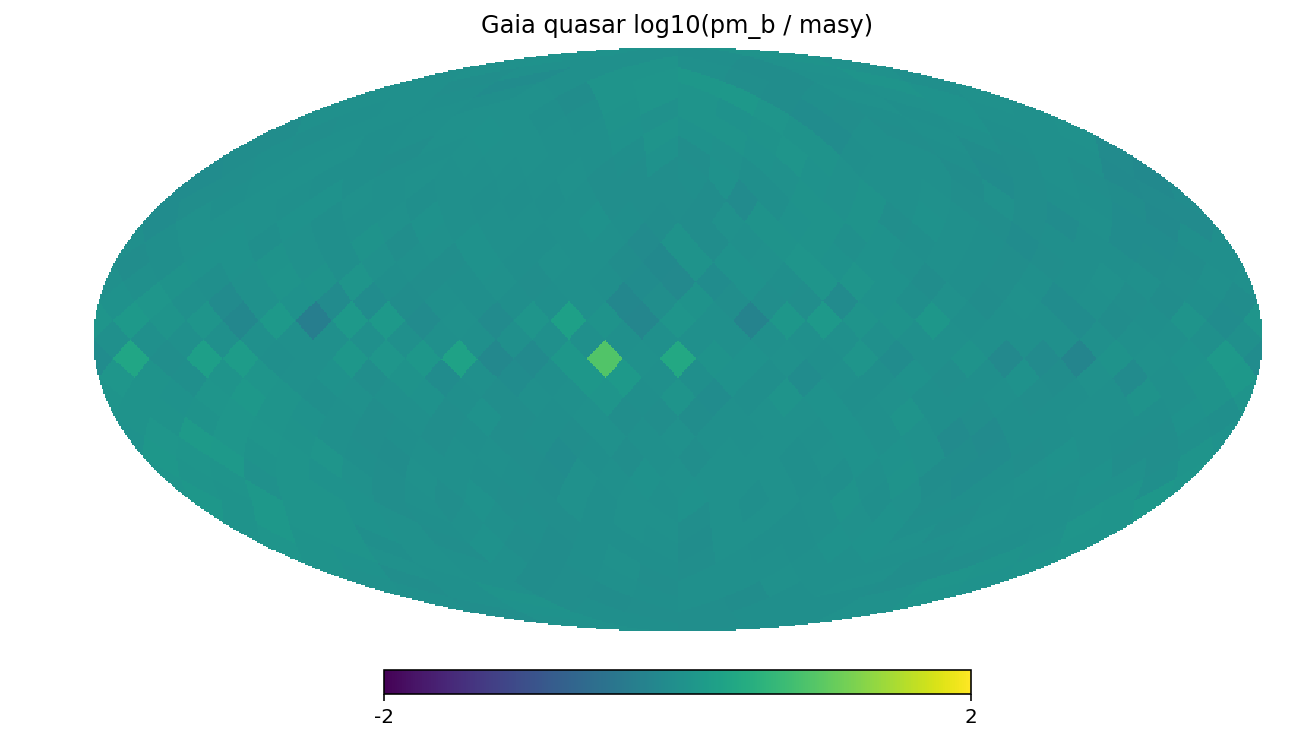

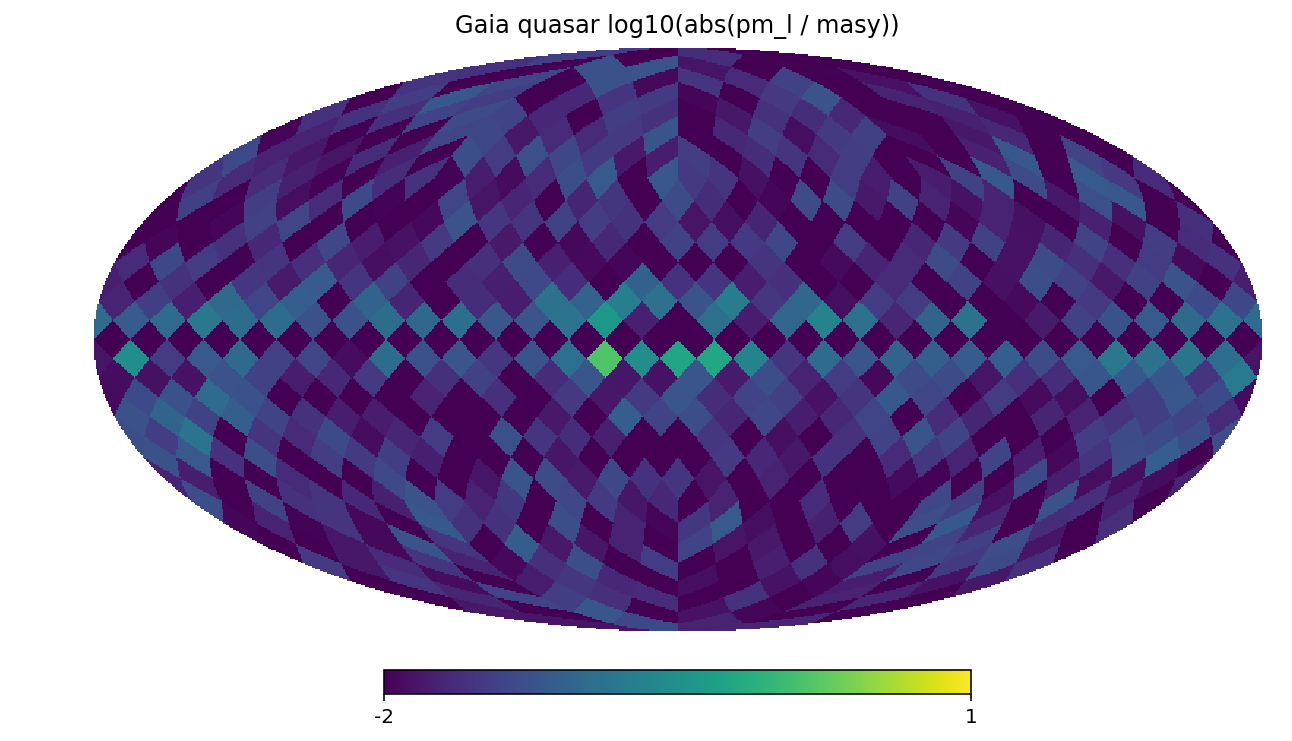

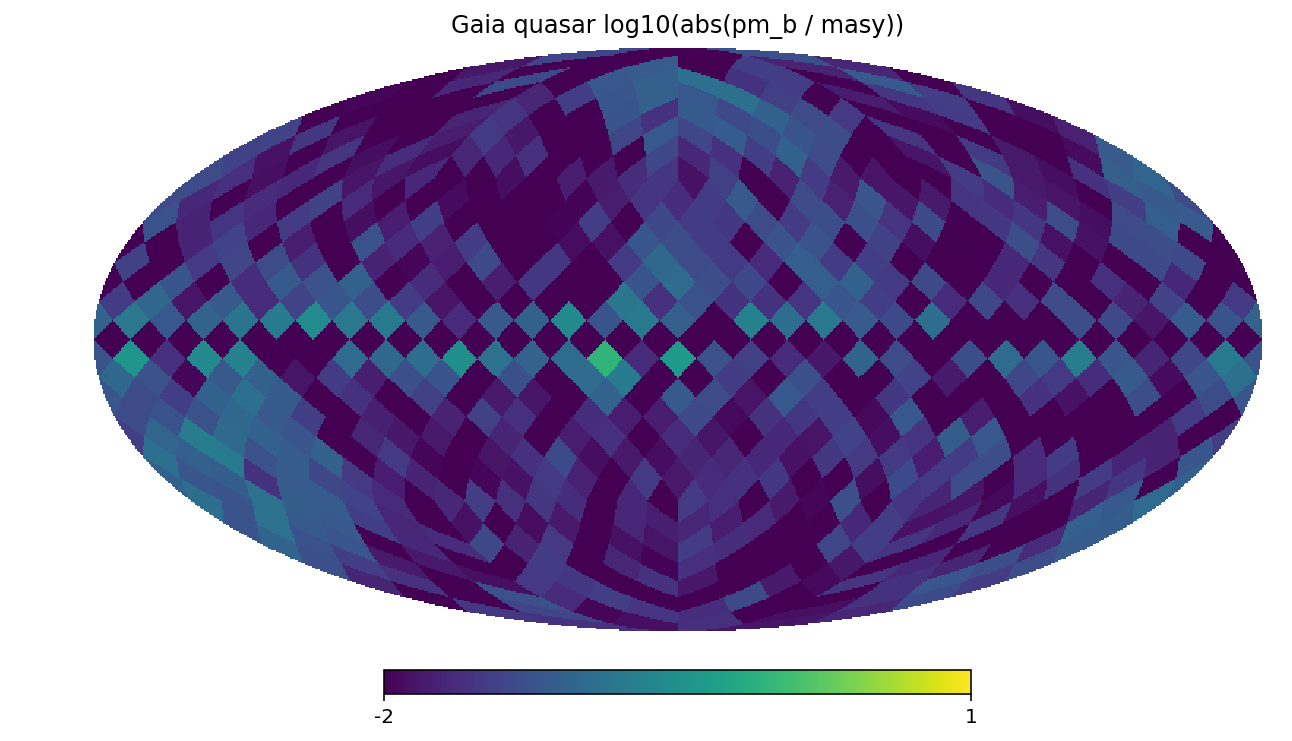

In [342]:
hp.mollview(pm_l_map, title="Gaia quasar log10(pm_l / masy)", min=-2, max=2)
hp.mollview(pm_b_map, title="Gaia quasar log10(pm_b / masy)", min=-2, max=2)
hp.mollview(np.log10(abs(pm_l_map)+10**(-6)), title="Gaia quasar log10(abs(pm_l / masy))",min=-2,max=1)
hp.mollview(np.log10(abs(pm_b_map)+10**(-6)), title="Gaia quasar log10(abs(pm_b / masy))",min=-2,max=1)

# Functions

## $Y$ harmonics

In [154]:
def fn_Yharm(l,m,theta,phi):
    return sph_harm(m,l,phi,theta)
    
#this runs much slower but is capable of going to much higher ell...
#from mpmath import spherharm
#def Yharm(l,m,theta,phi):
#    return complex(spherharm(l,m,theta,phi))

In [155]:
def fn_Yharm_map(l,m):
    """spherical harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l >= 0: #to avoid getting nan outputs when there are l = -1 calls
        for i in np.arange(npix):
            tmp_map[i] += fn_Yharm(l,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

## $\Psi$ harmonics

In [253]:
def fn_c_coeff(c_idx,l,m):
    if c_idx == 1:
        return np.sqrt((l+1)*(l-m)*(l+m) / ( (l)*(2*l-1)*(2*l+1) + 10**(-10)) )
    elif c_idx == 2:
        return - np.sqrt((l)*(l-m+1)*(l+m+1) / ( (l+1)*(2*l+3)*(2*l+1) + 10**(-10)) )
    elif c_idx == 3:
        return (1j)*m/np.sqrt(l*(l+1) + 10**(-10))

In [254]:
def fn_sin_map():
    """map of 1/sin(theta) over healpix map"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    for i in np.arange(npix):
        tmp_map[i] = np.sin(pix_coords[i,0])
    return tmp_map

In [255]:
def fn_sin_inv_map():
    """map of 1/sin(theta) over healpix map"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    for i in np.arange(npix):
        sin_val = np.sin(pix_coords[i,0])
        if abs(sin_val)>0:
            tmp_map[i]= 1/sin_val
        else:
            tmp_map[i]= 10**{40}       
    return tmp_map

In [256]:
def fn_Aharm_map(l,m):
    """A harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l > 0: #to avoid getting nan outputs when there are l = -1 calls
        if l > abs(m):
            for i in np.arange(npix):
                tmp_map[i] += fn_c_coeff(1,l,m)*fn_Yharm(l-1,m,pix_coords[i,0],pix_coords[i,1]) + fn_c_coeff(2,l,m)*fn_Yharm(l+1,m,pix_coords[i,0],pix_coords[i,1])
        elif l == abs(m): #to avoid getting nan outputs when l-1 < abs(m)
            for i in np.arange(npix):
                tmp_map[i] += fn_c_coeff(2,l,m)*fn_Yharm(l+1,m,pix_coords[i,0],pix_coords[i,1])
    elif l==0:
        for i in np.arange(npix):
            tmp_map[i] += fn_c_coeff(2,l,m)*fn_Yharm(l+1,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

def fn_Bharm_map(l,m):
    """B harmonic map over healpix with nside defined"""
    tmp_map = np.zeros(npix,dtype=np.complex)
    if l > 0: #to avoid dividing by zero
        for i in np.arange(npix):
            tmp_map[i] += fn_c_coeff(3,l,m)*fn_Yharm(l,m,pix_coords[i,0],pix_coords[i,1])
    return tmp_map

def fn_Psiharm_map(l,m):
    """Psi harmonic map over healpix with nside defined"""
    theta_comp_map = -fn_sin_inv_map()*fn_Aharm_map(l,m)
    phi_comp_map = -fn_sin_inv_map()*fn_Bharm_map(l,m)
    return np.transpose([theta_comp_map,phi_comp_map])

## Harmonic decomposition

In [160]:
from healpy.sphtfunc import Alm

def fn_alm_getidx(lmax,l,m):
    if m >= 0:
        return Alm.getidx(lmax,l,m)
    else:
        return round(0.5*lmax**2 + 1.5*lmax + 1) - (lmax+1) + Alm.getidx(lmax,l,abs(m))
    
def fn_alm_getlm(lmax,idx):
    if idx < round(0.5*lmax**2 + 1.5*lmax + 1):
        return Alm.getlm(lmax,idx)
    else:
        lm_pos =  Alm.getlm(lmax, idx - round(0.5*lmax**2 + 1.5*lmax + 1) + (lmax+1))
        return (lm_pos[0], -lm_pos[1])

In [161]:
def fn_complexmap2alm(map):
    alm_real = map2alm(np.real(map))
    alm_imag = map2alm(np.imag(map))
    alm_total = alm_real + alm_imag*1j
       
    for idx_lower in range(lmax+1, alm_real.size):
        alm_total = np.concatenate(( alm_total, [(-1)**Alm.getlm(lmax,idx_lower)[1] * (alm_real[idx_lower]-alm_imag[idx_lower]*1j)] ))    
    
    return alm_total

## Fisher matrix (1)

In [206]:
def fn_mat_Fisher1_fromPsi(weights_map): #unit weights map for now
    amp = np.zeros(((lmax+1)**2,(lmax+1)**2),dtype='complex')
    for idx in tqdm_notebook(range((lmax+1)**2)):
        l, m = fn_alm_getlm(lmax,idx)[0].item(), fn_alm_getlm(lmax,idx)[1].item()
        for idx_p in range((lmax+1)**2):
            l_p, m_p = fn_alm_getlm(lmax,idx_p)[0].item(), fn_alm_getlm(lmax,idx_p)[1].item()
            amp[idx,idx_p]=(4*np.pi/npix)*sum(sum(fn_Psiharm_map(l,m) * np.conj(fn_Psiharm_map(l_p,m_p))))
    return (1/2) * amp * np.transpose(amp)

$$ P^{(1) \ell m}_{i\alpha j \beta} = \Psi^{\ell m}_{i\alpha} \Psi^{\ell m *}_{j \beta}; \qquad 
\Psi^{\ell m}_{i \alpha} = \frac{-1}{\sin \theta_i} \left\lbrace \delta_{\alpha 1} \left[ c^{\ell m}_1 Y^{\ell-1, m}_i + c^{\ell m}_2 Y^{\ell+1, m}_i \right] + \delta_{\alpha 2} c^{\ell m}_3 Y^{\ell m}_i \right\rbrace $$
$$
c^{\ell m}_1 = \frac{\ell + 1}{\sqrt{\ell(\ell+1)}} \sqrt{\frac{(\ell - m)(\ell + m)}{(2\ell -1)(2\ell +1)}}; \qquad
c^{\ell m}_2 = \frac{-\ell}{\sqrt{\ell(\ell+1)}} \sqrt{\frac{(\ell - m+1)(\ell + m+1)}{(2\ell +3)(2\ell +1)}}; \qquad
c^{\ell m}_3 = \frac{i m}{\sqrt{\ell(\ell+1)}} 
$$
\begin{align}
F_{\ell m \ell' m'} &= \frac{1}{2} \sum_{i j \alpha \beta} \frac{P^{(1)\ell m}_{i \alpha j \beta} P^{(1)\ell' m'}_{j \beta i \alpha}}{N_i N_j} 
= \frac{1}{2} \left\lbrace \sum_{i \alpha} \frac{\Psi^{\ell m}_{i\alpha} \Psi^{\ell' m' *}_{i\alpha}}{N_i} \right\rbrace  \left\lbrace \sum_{j \beta} \frac{\Psi^{\ell' m'}_{j\beta} \Psi^{\ell m *}_{j\beta}}{N_j} \right\rbrace = \frac{1}{2} \tilde{P}_{\ell m \ell' m'} \tilde{P}_{\ell' m' \ell m} \\
\tilde{P}_{\ell m \ell' m'} &= c^{\ell' m'}_1 \tilde{\Psi}^{\ell m}_{1,\ell'-1,m'} + c^{\ell' m'}_2 \tilde{\Psi}^{\ell m}_{1,\ell'+1,m'} - c^{\ell' m'}_3 \tilde{\Psi}^{\ell m}_{2,\ell',m'} \\
\tilde{\Psi}^{\ell m}_{\alpha \ell' m'} &= \sum_i \frac{-1}{N_i \sin \theta_i} \Psi^{\ell m}_{i\alpha} Y^{\ell' m' *}_i
\end{align}

In [207]:
def fn_mat_Psitilde(weights_map):
    prefactor_map = -fn_sin_inv_map()*weights_map
    mat_Psitilde_1 = np.zeros(((lmax+1)**2,(lmax+1)**2),dtype='complex')
    mat_Psitilde_2 = np.zeros(((lmax+1)**2,(lmax+1)**2),dtype='complex')
    for idx in tqdm_notebook(range((lmax+1)**2)):
        l, m = fn_alm_getlm(lmax,idx)[0].item(), fn_alm_getlm(lmax,idx)[1].item()
        psiharm_map1,psiharm_map2 = fn_Psiharm_map(l,m)[:,0], fn_Psiharm_map(l,m)[:,1]
        mat_Psitilde_1[idx] = fn_complexmap2alm(prefactor_map*psiharm_map1)
        mat_Psitilde_2[idx] = fn_complexmap2alm(prefactor_map*psiharm_map2)
    return mat_Psitilde_1, mat_Psitilde_2

In [326]:
def fn_mat_Ptilde(weights_map):
    mat_Psitilde_1,mat_Psitilde_2 = fn_mat_Psitilde(weights_map)
    c1vec = np.zeros(lmax**2, dtype='complex') #create coefficient vectors
    c2vec = np.zeros(lmax**2, dtype='complex')
    c3vec = np.zeros(lmax**2, dtype='complex')
    for idx in range(lmax**2): #only go up to lmax-1 to avoid getting out of range on the l+1 recursion
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item() 
        c1vec[idx] = fn_c_coeff(1,l,m)*min(l,1) #multiplier to handle l==0 exception
        c2vec[idx], c3vec[idx] =  fn_c_coeff(2,l,m), fn_c_coeff(3,l,abs(m)) #why abs(m)?
    vec_idx_zero = np.zeros(lmax**2, dtype='int') #create permutation vectors to select parts of Psitilde matrices
    vec_idx_minus = np.zeros(lmax**2, dtype='int')
    vec_idx_plus = np.zeros(lmax**2, dtype='int')
    for idx in range(lmax**2):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        vec_idx_zero[idx] = fn_alm_getidx(lmax,l,m)
        vec_idx_minus[idx] = fn_alm_getidx(lmax,l-1,m)
        vec_idx_plus[idx] = fn_alm_getidx(lmax,l+1,m)
    mat_Psitilde_2_zero = -np.transpose(c3vec * np.transpose(mat_Psitilde_2[vec_idx_zero][:,vec_idx_zero]))
    mat_Psitilde_1_minus = np.transpose(c1vec * np.transpose(mat_Psitilde_1[vec_idx_zero][:,vec_idx_minus]))
    mat_Psitilde_1_plus = np.transpose(c2vec * np.transpose(mat_Psitilde_1[vec_idx_zero][:,vec_idx_plus]))
    mat_Ptilde = mat_Psitilde_1_minus + mat_Psitilde_1_plus + mat_Psitilde_2_zero
    return mat_Ptilde

In [327]:
def fn_mat_Ptilde_large(weights_map):
    mat_Psitilde_1,mat_Psitilde_2 = fn_mat_Psitilde(weights_map)
    mat_Ptilde = np.zeros(((lmax+1)**2,(lmax+1)**2),dtype='complex')
    for idx in range((lmax+1)**2): 
        l, m = fn_alm_getlm(lmax,idx)[0].item(), fn_alm_getlm(lmax,idx)[1].item()
        for idx_p in range((lmax+1)**2):
            l_p, m_p = fn_alm_getlm(lmax,idx_p)[0].item(), fn_alm_getlm(lmax,idx_p)[1].item()
            if max(l,l_p)<lmax: #only go up to lmax-1 to avoid getting out of range on the l+1 recursion
                idx_p_minus = fn_alm_getidx(lmax,l_p-1,m_p)
                idx_p_plus = fn_alm_getidx(lmax,l_p+1,m_p)
                mat_Ptilde[idx,idx_p] += fn_c_coeff(1,l_p,m_p)*mat_Psitilde_1[idx,idx_p_minus] 
                mat_Ptilde[idx,idx_p] += fn_c_coeff(2,l_p,m_p)*mat_Psitilde_1[idx,idx_p_plus] 
                mat_Ptilde[idx,idx_p] += fn_c_coeff(3,l_p,abs(m_p))*mat_Psitilde_2[idx,idx_p] #why abs(m_p)?
    return mat_Ptilde

In [369]:
def fn_mat_Fisher1(weights_map):
    mat_Ptilde = fn_mat_Ptilde(weights_map)
    return 0.5 * np.real(mat_Ptilde * np.transpose(mat_Ptilde))

In [370]:
def fn_mat_Fisher1_inv(mat_fisher1):
    matfish_block = mat_fisher1[1:,1:]
    matfish_block_inv = np.real(np.linalg.inv(matfish_block))
    return np.pad(matfish_block_inv,((1,0),(1,0)),'constant')

## Signal numerator of power spectrum

In [403]:
def fn_mat_num1_sig(data_map_b,data_map_l,weights_map):
    dtilde_map_b = fn_sin_inv_map()*weights_map*data_map_b
    dtilde_map_l = fn_sin_inv_map()*weights_map*data_map_l
    dtilde_b_lm = fn_complexmap2alm(dtilde_map_b)
    dtilde_l_lm = fn_complexmap2alm(dtilde_map_l)
    c1vec = np.zeros(lmax**2, dtype='complex') #create coefficient vectors
    c2vec = np.zeros(lmax**2, dtype='complex')
    c3vec = np.zeros(lmax**2, dtype='complex')
    for idx in range(lmax**2): #only go up to lmax-1 to avoid getting out of range on the l+1 recursion
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item() 
        c1vec[idx] = fn_c_coeff(1,l,m)*min(l,1) #multiplier to handle l==0 exception
        c2vec[idx], c3vec[idx] =  fn_c_coeff(2,l,m), fn_c_coeff(3,l,m)
    vec_idx_zero = np.zeros(lmax**2, dtype='int') #create permutation vectors to select parts of A and B matrices
    vec_idx_minus = np.zeros(lmax**2, dtype='int')
    vec_idx_plus = np.zeros(lmax**2, dtype='int')
    for idx in range(lmax**2):
        l, m = fn_alm_getlm(lmax-1,idx)[0].item(), fn_alm_getlm(lmax-1,idx)[1].item()
        vec_idx_zero[idx] = fn_alm_getidx(lmax,l,m)
        vec_idx_minus[idx] = fn_alm_getidx(lmax,l-1,m)
        vec_idx_plus[idx] = fn_alm_getidx(lmax,l+1,m)
    dtilde_l_lm_zero  = dtilde_l_lm[vec_idx_zero]
    dtilde_b_lm_minus = dtilde_b_lm[vec_idx_minus]
    dtilde_b_lm_plus  = dtilde_b_lm[vec_idx_plus]
    amp = c1vec*dtilde_b_lm_minus + c2vec*dtilde_b_lm_plus - c3vec*dtilde_l_lm_zero
    return np.real(amp * np.conjugate(amp))

## Data manipulation

In [367]:
def fn_arr_pow_spec(pow_spec): #converts idx components into (l,m) array
    lmax = (np.sqrt(pow_spec.shape[0])-1).astype(int)
    tmp_mat = np.zeros((lmax+1,lmax+1))+10**(-100)
    for l in range(lmax+1):
        for m in range(l+1):
            idx = fn_alm_getidx(lmax,l,m)
            tmp_mat[m,l] += pow_spec[idx]
    return tmp_mat

### Debug

## Tests

### $Y$ harmonics

### Harmonic decomposition

### $\Psi$ harmonics

### Fisher matrix (1)

### Signal numerator of power spectrum

# Vector Power Spectrum

## Computation

### Fisher matrix

In [492]:
#weights_map = 1
weights_map = pm_N_map**(-1)
mat_fisher1 = fn_mat_Fisher1(weights_map)
mat_fisher1_inv = fn_mat_Fisher1_inv(mat_fisher1)

### Power spectrum

In [503]:
#l_fake, m_fake = 7,2
#data_map_b, data_map_l = fn_Psiharm_map(l_fake,m_fake)[:,0],fn_Psiharm_map(l_fake,m_fake)[:,1]
data_map_b, data_map_l = pm_b_map, pm_l_map
mat_num1_sig = fn_mat_num1_sig(data_map_b, data_map_l,weights_map)
mat_pow1_spec = (1/2) * mat_fisher1_inv @ mat_num1_sig

In [505]:
mat_pow1_spec

array([ 0.00000000e+00,  1.09773803e-03,  1.05797958e-04, ...,  1.94806254e-04,  4.09030929e-06, -4.15511572e-06])

In [506]:
mat_pow1_spec.shape

(2209,)

## Plots

### Fisher matrix

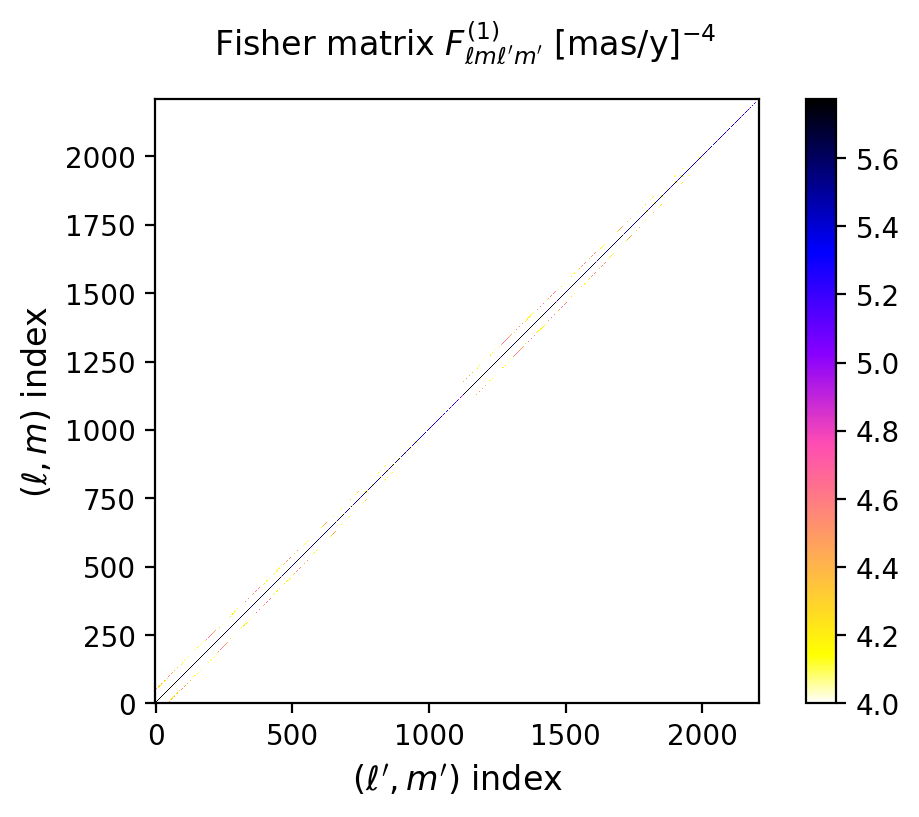

In [493]:
fig_mat_fisher1 = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(mat_fisher1+10**(-30))), origin='lower', vmin=4, cmap = 'gnuplot2_r');
plt.suptitle('Fisher matrix $F^{(1)}_{\ell m \ell^{\prime} m^\prime}$ $[\mathrm{mas/y}]^{-4}$', fontsize=12)
plt.xlabel('$(\ell^\prime,m^\prime)$ index', fontsize=12)
plt.ylabel('$(\ell,m)$ index', fontsize=12)
plt.colorbar()
plt.show()
fig_mat_fisher1.savefig('mat_fisher1.pdf')

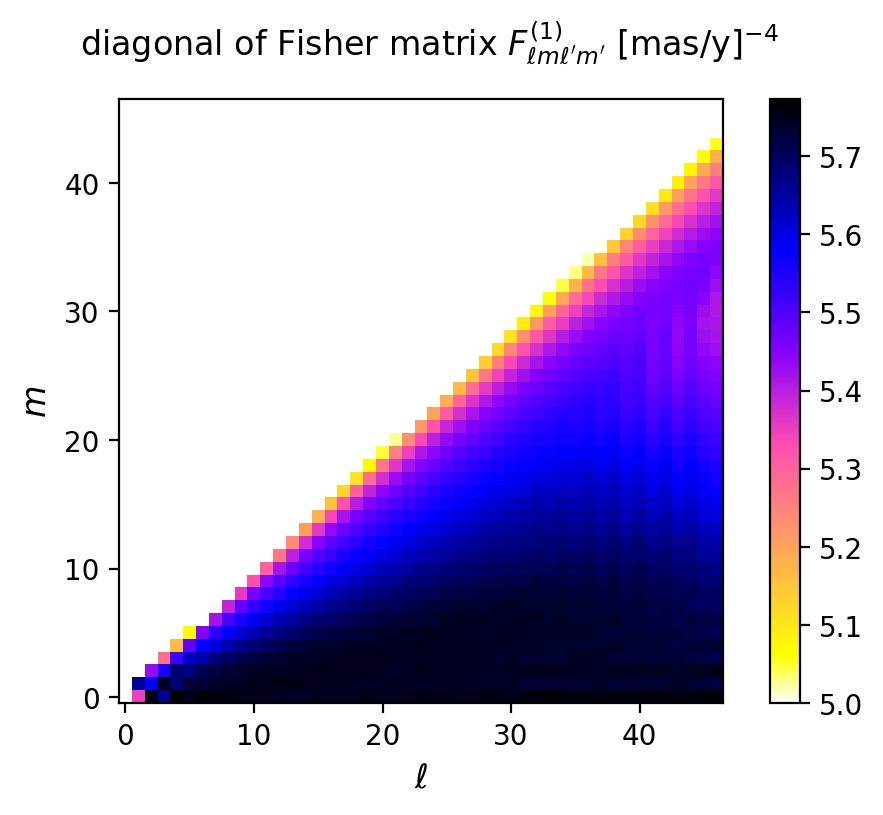

In [494]:
fig_diag_fisher1 = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(fn_arr_pow_spec(np.diag(mat_fisher1)))),  origin='lower', vmin=5, vmax=None, cmap = 'gnuplot2_r');
plt.suptitle('diagonal of Fisher matrix $F^{(1)}_{\ell m \ell^{\prime} m^\prime}$ $[\mathrm{mas/y}]^{-4}$', fontsize=12)
plt.xlabel('$\ell$', fontsize=12)
plt.ylabel('$m$', fontsize=12)
plt.colorbar()
plt.show()
fig_diag_fisher1.savefig('diag_fisher1.pdf')

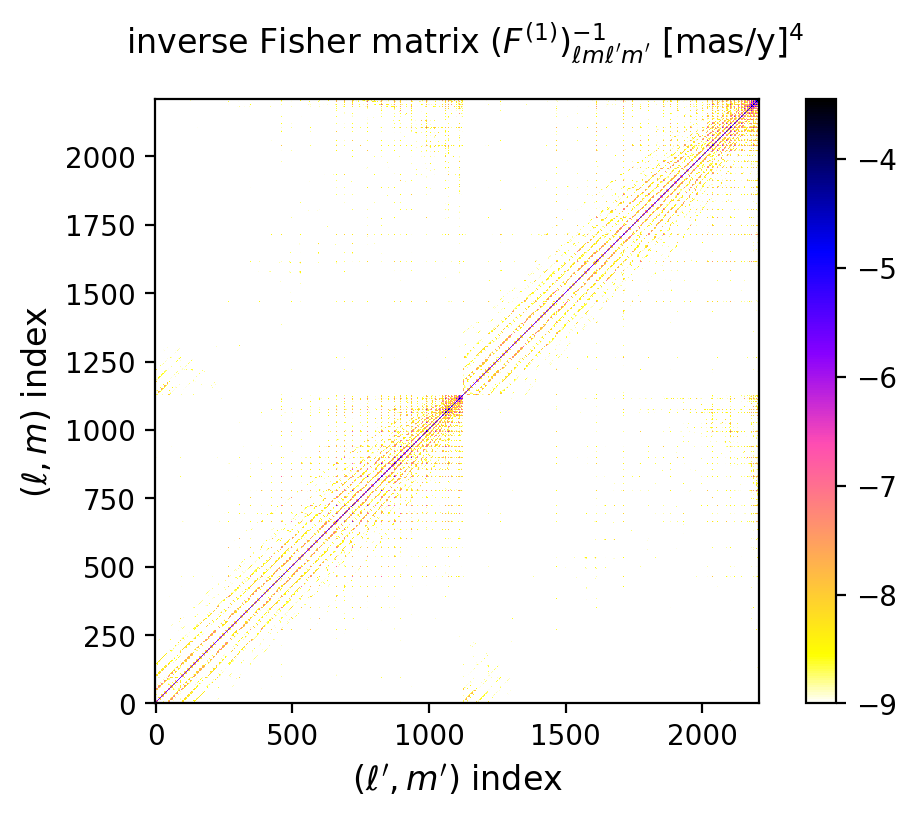

In [495]:
fig_mat_fisher1_inv = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(mat_fisher1_inv+10**(-30))), origin='lower', vmin=-9, cmap = 'gnuplot2_r');
plt.suptitle('inverse Fisher matrix $(F^{(1)})^{-1}_{\ell m \ell^{\prime} m^\prime}$ $[\mathrm{mas/y}]^{4}$', fontsize=12)
plt.xlabel('$(\ell^\prime,m^\prime)$ index', fontsize=12)
plt.ylabel('$(\ell,m)$ index', fontsize=12)
plt.colorbar()
plt.show()
fig_mat_fisher1_inv.savefig('mat_fisher1_inv.pdf')

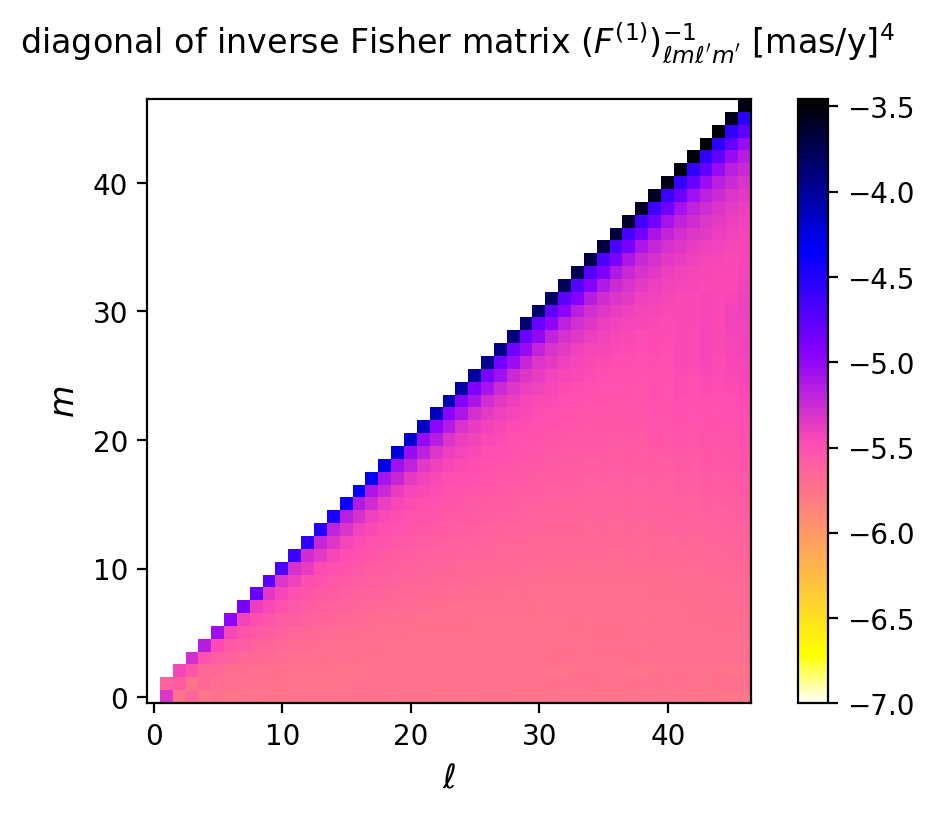

In [496]:
fig_diag_fisher1_inv = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(fn_arr_pow_spec(np.diag(mat_fisher1_inv)))),  origin='lower', vmin=-7, vmax=None, cmap = 'gnuplot2_r');
plt.suptitle('diagonal of inverse Fisher matrix $(F^{(1)})^{-1}_{\ell m \ell^{\prime} m^\prime}$ $[\mathrm{mas/y}]^{4}$', fontsize=12)
plt.xlabel('$\ell$', fontsize=12)
plt.ylabel('$m$', fontsize=12)
plt.colorbar()
plt.show()
fig_diag_fisher1_inv.savefig('diag_fisher1_inv.pdf')

### Power spectrum

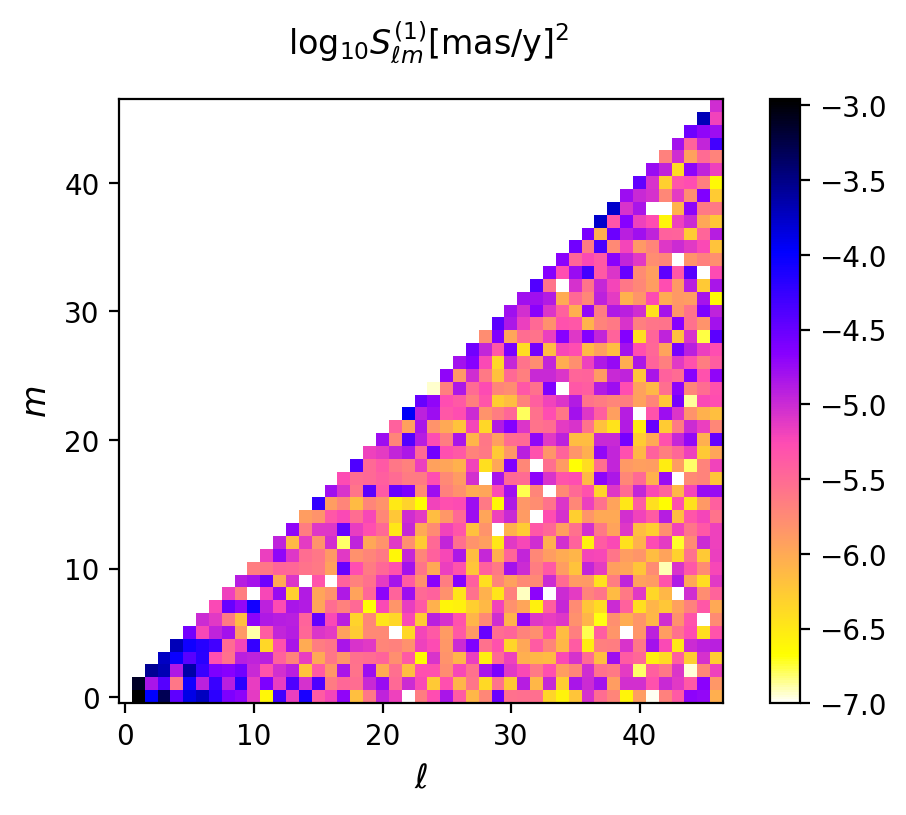

In [509]:
fig_pow1_spec = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(fn_arr_pow_spec(mat_pow1_spec))),  origin='lower', vmin=-7, vmax=None, cmap='gnuplot2_r');
plt.suptitle('$\log_{10}S^{(1)}_{\ell m} [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
plt.xlabel('$\ell$', fontsize=12)
plt.ylabel('$m$', fontsize=12)
plt.colorbar()
plt.show()
fig_pow1_spec.savefig('pow1_spec.pdf')

In [430]:
fig_pow1_spec = plt.figure(num=None, figsize=(6,4), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.log10(abs(fn_arr_pow_spec_full(mat_pow1_spec))),  origin='lower', vmin=-3, vmax=None, cmap='gnuplot2_r');
plt.suptitle('$\log_{10}S^{(1)}_{\ell m} [\mathrm{mas}/\mathrm{y}]^2$', fontsize=12)
plt.xlabel('$\ell$', fontsize=12)
plt.ylabel('$m$', fontsize=12)
plt.colorbar()
plt.show()
fig_pow1_spec.savefig('pow1_spec.pdf')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 600x400 with 0 Axes>